### Project Topic: Adult Screening of Autistic Spectrum Disorder

Autistic Spectrum Disorder (ASD) is a neurodevelopment condition associated with significant healthcare costs, which can be reduced through early diagnosis.  Unfortunately, wait times for an ASD diagnosis are lengthy and procedures are not cost effective. The economic impact of autism and the increase in the number of ASD cases across the world reveals an urgent need for the development of effective and easily implemented screening methods. This project looks to predict whether an adult patient has ASD based on responses to the AQ-10 questionaire along with family history and demographical information. Because the data is mostly categorical, it lends itself to using the supervised learning algothrithms: Decision Trees and Random Forest Classification.

Many adults with autism spectrum disorder (ASD) remain undiagnosed. The goal of the project is to see if it's possible to accurately predict if an adult patient has ASD based on their responses to a commonly used AQ-10 questionaire and other provided demographic data.  

### Project Data

Thabtah, F. (2017). Autism Screening Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5F019. 

  The data was found on the UC Irvine Machine Learning Repository.  There are 704 samples of adults aged 17-61.  The 20 features include responses to AQ-10 test (binary) along with 10 other family history and demographical information (mostly categorical).  The data was already split into feature and target sets as seen in the code below.  

In [1]:
%pip install ucimlrepo
!git clone https://github.com/ayanatherate/dfcorrs.git
!pip install nbformat 

Note: you may need to restart the kernel to use updated packages.
fatal: destination path 'dfcorrs' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import phik
from phik import resources, report
from dfcorrs.cramersvcorr import Cramers


In [3]:

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
autism_screening_adult = fetch_ucirepo(id=426) 
  
# data (as pandas dataframes) 
X = autism_screening_adult.data.features 
y = autism_screening_adult.data.targets 
  
# metadata 
print(autism_screening_adult.metadata) 
  
# variable information 
print(autism_screening_adult.variables) 


{'uci_id': 426, 'name': 'Autism Screening Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/426/autism+screening+adult', 'data_url': 'https://archive.ics.uci.edu/static/public/426/data.csv', 'abstract': 'Autistic Spectrum Disorder Screening Data for Adult. This dataset is related to classification and predictive tasks.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': [], 'num_instances': 704, 'num_features': 20, 'feature_types': ['Integer'], 'demographics': ['Age', 'Gender', 'Ethnicity', 'Nationality'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2017, 'last_updated': 'Thu Mar 28 2024', 'dataset_doi': '10.24432/C5F019', 'creators': ['Fadi Thabtah'], 'intro_paper': None, 'additional_info': {'summary': "See attached variables' description file ", 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': 

### Cleaning Feature Dataset X

From the initial variables output I could see that there were missing values in the age, ethnicity and relation features.  To get a better idea of what the dataset looked like, I printed out the unique responses for each category as seen below.

In [4]:
for c in X.columns[:]:
    print(c, X[c].unique())

A1_Score [1 0]
A2_Score [1 0]
A3_Score [1 0]
A4_Score [1 0]
A5_Score [0 1]
A6_Score [0 1]
A7_Score [1 0]
A8_Score [1 0]
A9_Score [0 1]
A10_Score [0 1]
age [ 26.  24.  27.  35.  40.  36.  17.  64.  29.  33.  18.  31.  30.  34.
  38.  42.  43.  48.  37.  55.  50.  53.  20.  28.  21. 383.  47.  32.
  44.  nan  19.  58.  45.  22.  39.  25.  23.  54.  60.  41.  46.  56.
  61.  59.  52.  49.  51.]
gender ['f' 'm']
ethnicity ['White-European' 'Latino' nan 'Others' 'Black' 'Asian'
 "'Middle Eastern '" 'Pasifika' "'South Asian'" 'Hispanic' 'Turkish'
 'others']
jaundice ['no' 'yes']
family_pdd ['no' 'yes']
country_of_res ["'United States'" 'Brazil' 'Spain' 'Egypt' "'New Zealand'" 'Bahamas'
 'Burundi' 'Austria' 'Argentina' 'Jordan' 'Ireland'
 "'United Arab Emirates'" 'Afghanistan' 'Lebanon' "'United Kingdom'"
 "'South Africa'" 'Italy' 'Pakistan' 'Bangladesh' 'Chile' 'France' 'China'
 'Australia' 'Canada' "'Saudi Arabia'" 'Netherlands' 'Romania' 'Sweden'
 'Tonga' 'Oman' 'India' 'Philippines' "'Sri

As seen above:
- AQ-10 responses: Binary, appear clean.
- age: Integer, Obvious outlier/miskey (383) and NaN.
- gender: Binary, M/F that can be changed to 1/0.  
- ethnicity: Categorical, NaN, 2 different others responses that can be combined.
- jaundice: Binary, Y/N that can be changed to 1/0.
- family_pdd: Binary, Y/N that can be changed to 1/0.
- country_of_res: Categorical, Appears clean.
- used_app_before: Binary, Y/N that can be changed to 1/0. (Curious how this was considered predictor of Autism) 
- result: Integer, Appears clean.
- age_desc: Only one response that encompasses all but one of the ages.
- relation: NaN (Curious how this was considered predictor of Autism) 

To resolve the issues stated above, I ran the following the code.  A print out to see the changes is included.
 

In [5]:
Xclean=X.copy()
Xclean.jaundice.replace(('yes', 'no'), (1, 0), inplace=True)
Xclean.family_pdd.replace(('yes', 'no'), (1, 0), inplace=True)
Xclean.gender.replace(('m', 'f'), (1,0), inplace=True)
Xclean.age.replace(383, 38, inplace=True)
Xclean.ethnicity.replace('others', 'Others', inplace=True)
Xclean['ethnicity'].fillna('Others', inplace=True)
Xclean.drop(['age_desc', 'relation', 'used_app_before'], axis=1, inplace=True)
mean_value = int(Xclean['age'].mean())
Xclean['age'].fillna(value=mean_value, inplace=True) 
for c in Xclean.columns[:]:
    print(c, Xclean[c].unique())

A1_Score [1 0]
A2_Score [1 0]
A3_Score [1 0]
A4_Score [1 0]
A5_Score [0 1]
A6_Score [0 1]
A7_Score [1 0]
A8_Score [1 0]
A9_Score [0 1]
A10_Score [0 1]
age [26. 24. 27. 35. 40. 36. 17. 64. 29. 33. 18. 31. 30. 34. 38. 42. 43. 48.
 37. 55. 50. 53. 20. 28. 21. 47. 32. 44. 19. 58. 45. 22. 39. 25. 23. 54.
 60. 41. 46. 56. 61. 59. 52. 49. 51.]
gender [0 1]
ethnicity ['White-European' 'Latino' 'Others' 'Black' 'Asian' "'Middle Eastern '"
 'Pasifika' "'South Asian'" 'Hispanic' 'Turkish']
jaundice [0 1]
family_pdd [0 1]
country_of_res ["'United States'" 'Brazil' 'Spain' 'Egypt' "'New Zealand'" 'Bahamas'
 'Burundi' 'Austria' 'Argentina' 'Jordan' 'Ireland'
 "'United Arab Emirates'" 'Afghanistan' 'Lebanon' "'United Kingdom'"
 "'South Africa'" 'Italy' 'Pakistan' 'Bangladesh' 'Chile' 'France' 'China'
 'Australia' 'Canada' "'Saudi Arabia'" 'Netherlands' 'Romania' 'Sweden'
 'Tonga' 'Oman' 'India' 'Philippines' "'Sri Lanka'" "'Sierra Leone'"
 'Ethiopia' "'Viet Nam'" 'Iran' "'Costa Rica'" 'Germany' 'Mexi

### Prepping Target Dataset y

There are no missing values in the target set, but when looking at the header, the data is in Y/N instead of 1/-1 form

Both ethnicity and country_of_res features are categorical data that will be encoded to be handled in models.

### Check for Imbalances in Data

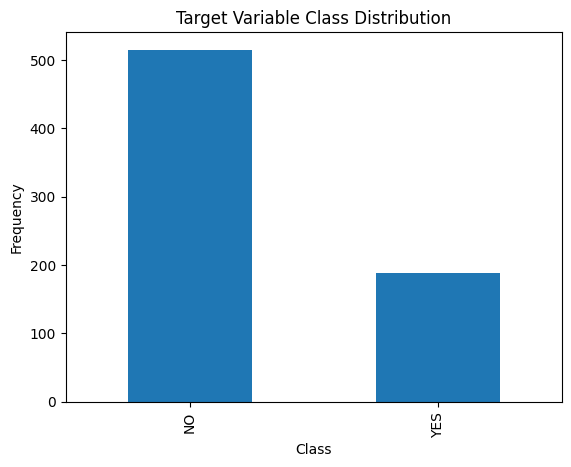

In [6]:
#Check for Imbalance
target_counts = y['class'].value_counts()

#Create Visualization
target_counts.plot(kind='bar')
plt.title('Target Variable Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

Considering only about 1% of the population is supsected to have ASD, the target data seems sufficiently balanced.

Now the feature data will be checked using pie charts, starting with the responses to the AQ 10 survey:

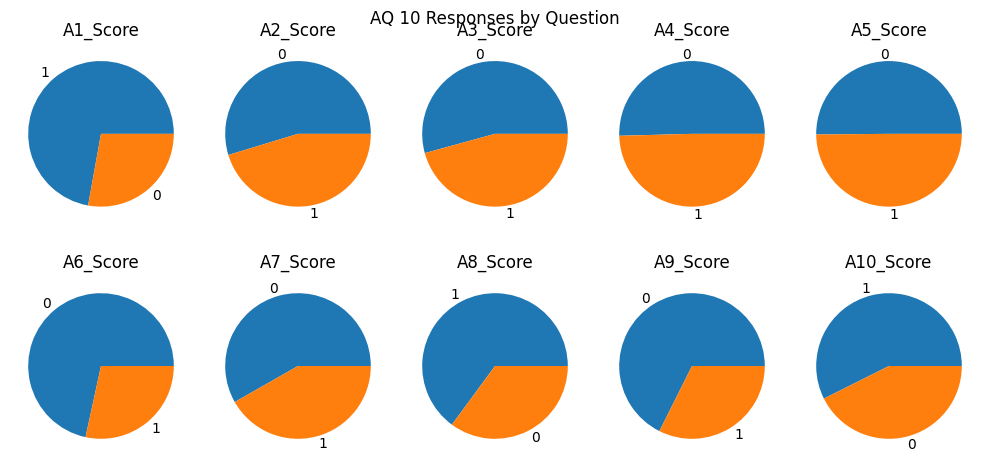

In [7]:
#Create subplots
fig, axs = plt.subplots(2, 5, figsize=(10,5))
j=0
k=0
# Plot pie charts
for i, col in enumerate(Xclean.columns[:10]):
    counts = Xclean[col].value_counts()
    axs[j,k].pie(counts, labels=counts.index)
    axs[j,k].set_title(col)
    if k < 4:
        k+=1
    elif j < 1:
        k=0
        j+=1
plt.tight_layout()
fig.suptitle('AQ 10 Responses by Question')    
plt.show()

The responses to the questionaire seem balanced, now the demographic features will be checked.  I left labels off the categorical data for readibility:

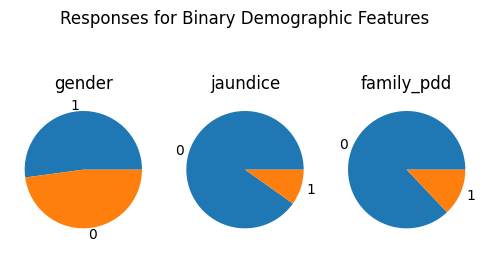

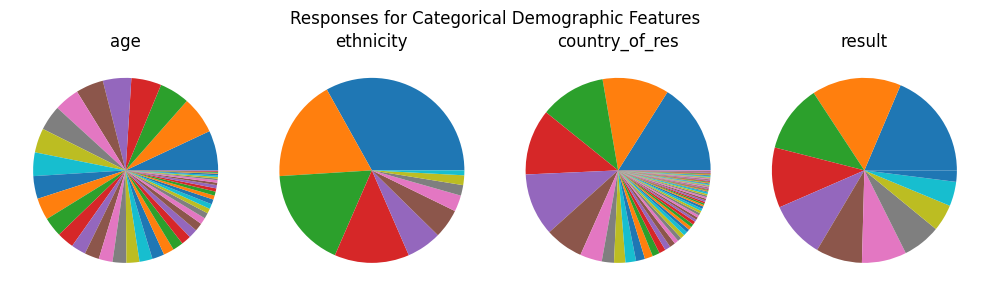

In [8]:
# Create the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(5,3))

# First row (3 subplots)
counts = Xclean[Xclean.columns[11]].value_counts()
axs[0].pie(counts, labels=counts.index)
axs[0].set_title(Xclean.columns[11])
counts = Xclean[Xclean.columns[13]].value_counts()
axs[1].pie(counts, labels=counts.index)
axs[1].set_title(Xclean.columns[13])
counts = Xclean[Xclean.columns[14]].value_counts()
axs[2].pie(counts, labels=counts.index)
axs[2].set_title(Xclean.columns[14])

fig.suptitle('Responses for Binary Demographic Features')   
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Create the figure and axes
fig, axs = plt.subplots(1, 4, figsize=(10,3))

# Second row (4 subplots)
counts = Xclean[Xclean.columns[10]].value_counts()
axs[0].pie(counts)
axs[0].set_title(Xclean.columns[10])
counts = Xclean[Xclean.columns[12]].value_counts()
axs[1].pie(counts)
axs[1].set_title(X.columns[12])
counts = Xclean[Xclean.columns[15]].value_counts()
axs[2].pie(counts)
axs[2].set_title(Xclean.columns[15])
counts = Xclean[Xclean.columns[16]].value_counts()
axs[3].pie(counts)
axs[3].set_title(Xclean.columns[16])

fig.suptitle('Responses for Categorical Demographic Features') 
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Exploratory Data Analysis

Because responses to the AQ-10 questionaire are binary data, I will create a heatmap using the Phi Coefficient to visualize the correlation between features:

interval columns not set, guessing: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']


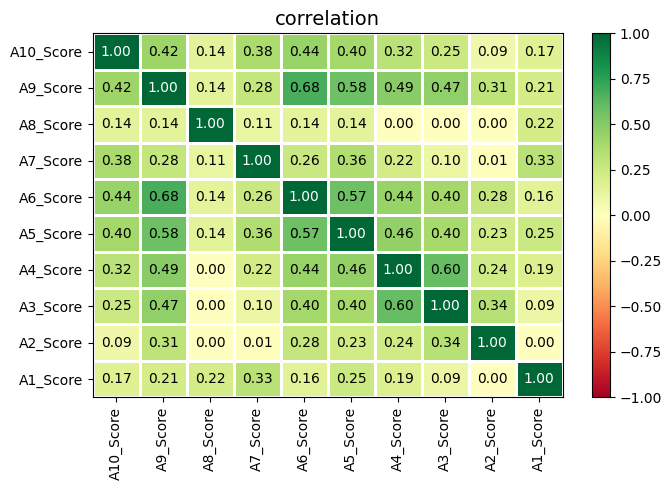

In [9]:
#Create df with only AQ-10 Columns
AQ10df = Xclean.iloc[:, 0:10]
phik_matrix = AQ10df.phik_matrix()

report.plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns,  y_labels=phik_matrix.index)

From the matrix, I can see that there is significant correlation between responses to some the questions.  Questions 6 and 9 are strongly correlated, and Questions 3 and 4, 5 and 9, and 5 and 6 are all moderately correlated.  This will need to be taken into consideration for tests other than Random Forest Classification.  

Now Cramer's V Correlation Analysis will be used to test features that are categorical (including binary):


In [10]:
cramers=Cramers()
cramers.corr(Xclean, plot_htmp=True)

The heatmap of Cramer's V correlation coefficients shows that the result (sum of Yes responses on AQ-10) is highly or moderately correlated to a number to the questions on the survey.  It also shows the correlation between questions detected by the above (green) phi coefficient correlation matrix.  As expected Ethnicity and Country of Residence are moderately coorelated with a coeficient of .51.  All other none survey data (ie jaundice, family_pdd, gender) seems independent.

Finally to check feature importance, a DecisionTreeClassifer model will be created and visualized.

First, categorical data will be encoded:

In [11]:
#Encode Categorical Data
ohe = OneHotEncoder()
encoded_data = ohe.fit_transform(Xclean[['ethnicity']])
X_encoded = pd.DataFrame(encoded_data.toarray(), columns=ohe.get_feature_names_out(['ethnicity']))
X_NC = pd.concat([Xclean.drop('ethnicity', axis=1), X_encoded], axis=1)
encoded_data = ohe.fit_transform(X_NC[['country_of_res']])
X_encoded = pd.DataFrame(encoded_data.toarray(), columns=ohe.get_feature_names_out(['country_of_res']))
X_NC = pd.concat([X_NC.drop('country_of_res', axis=1), X_encoded], axis=1)

Next, DecisionTreeClassier is created to test feature importance:

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 1.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

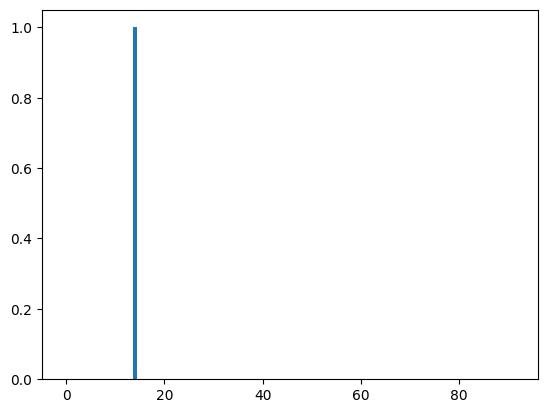

result


In [12]:
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_NC, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(X_NC.columns[14])

From this test, feature 14 (result) was the only important feature in the tree.  In encoding the categorical data, many features were created.  Those features will be removed and feature importance will be checked again.

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 1.00000


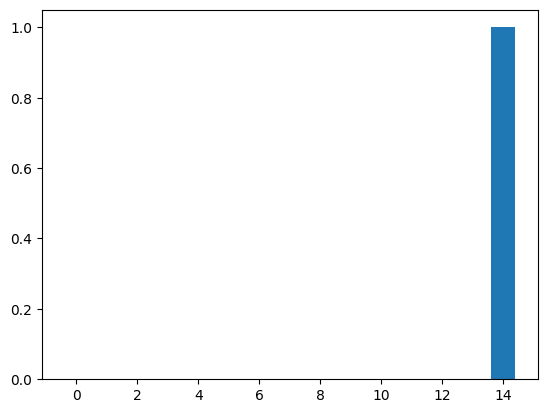

In [13]:
Xclean.drop(['ethnicity', 'country_of_res',], axis=1, inplace=True)
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(Xclean, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

It appears even without the dilution of the added encoded features, for a decision tree classier, the only feature that matters is the sum of yes responses on the AQ-10.  This makes sense, as the questionaire was created to detect ASD.  As this seems like a simple problem, I'll continue and use different models to compare how they perform.  Perhaps the results can give insight into similar situations where a dominate feature exists.  Out of curiousity, next Feature 14 (result) will be removed to compare the importance of the remaining features, giving more insight into the problem.

Feature: 0, Score: 0.04290
Feature: 1, Score: 0.03846
Feature: 2, Score: 0.06010
Feature: 3, Score: 0.04856
Feature: 4, Score: 0.12347
Feature: 5, Score: 0.06760
Feature: 6, Score: 0.06692
Feature: 7, Score: 0.03409
Feature: 8, Score: 0.40396
Feature: 9, Score: 0.04562
Feature: 10, Score: 0.03566
Feature: 11, Score: 0.00151
Feature: 12, Score: 0.00668
Feature: 13, Score: 0.02449


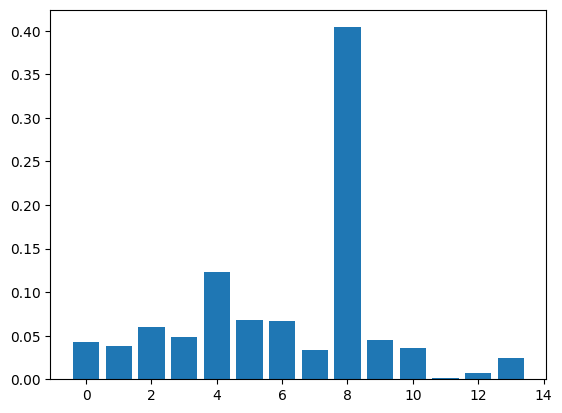

Feature 8: A9_Score
Feature 4: A5_Score


In [14]:
Drop14=Xclean.copy()
Drop14.drop(['result'], axis=1, inplace=True)
# define the model
dtc = DecisionTreeClassifier()
# fit the model
dtc.fit(Drop14, y)

# get importance
importance = dtc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(f"Feature 8: {Drop14.columns[8]}")
print(f"Feature 4: {Drop14.columns[4]}")

This bar graph shows that with the result feature removed, responses to question 9 and question 5 are the most predictative of ASD according to the decision tree classifier.  Those responses were found to be moderately correlated with each other.

### Models

Knowing that there is some strong to moderate correlation between AQ-10 question responses, the most fitting model for the problem appears to be Random Forest Classification. To have a baseline model, a Random Forest model with 100 trees was trained and evaluated.

Accuracy: 1.0
Feature: 0, Score: 0.02493
Feature: 1, Score: 0.02329
Feature: 2, Score: 0.04356
Feature: 3, Score: 0.03479
Feature: 4, Score: 0.06523
Feature: 5, Score: 0.09679
Feature: 6, Score: 0.03162
Feature: 7, Score: 0.01512
Feature: 8, Score: 0.11822
Feature: 9, Score: 0.02469
Feature: 10, Score: 0.01978
Feature: 11, Score: 0.00425
Feature: 12, Score: 0.00217
Feature: 13, Score: 0.00344
Feature: 14, Score: 0.49213


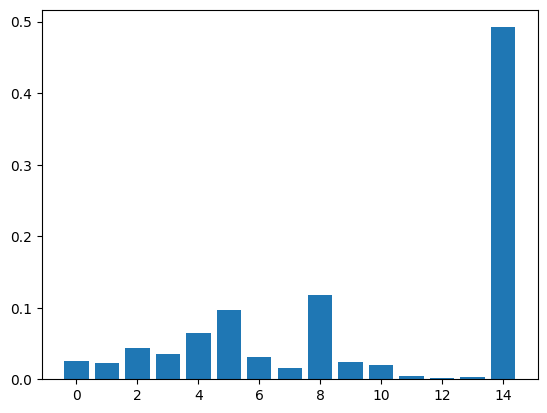

In [15]:
#create training and testing data set

X_train, X_test, y_train, y_test = train_test_split(Xclean, y, test_size=0.2, random_state=42)

#build and fit model
rfc = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train,y_train)

#test model, calculate accuracy
yhat = rfc.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy:', accuracy)

importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


Well, 100% accuracy is as good as it gets!  What is the minimum number of trees needed to acheive those results?

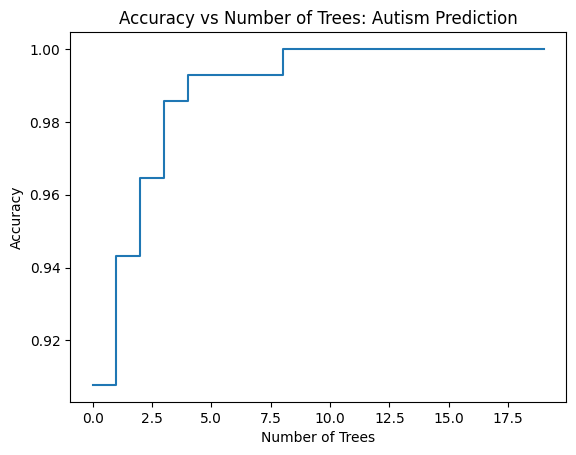

In [16]:
#Random Forest Baseline
n_estimators=list(range(1,21))
accuracy_list=[]
for e in n_estimators:
    rfc = RandomForestClassifier(n_estimators=e, random_state=42).fit(X_train,y_train)
    yhat = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    accuracy_list.append(accuracy)
#print('Accuracy:', accuracy)

fig, ax = plt.subplots()
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Number of Trees: Autism Prediction")
ax.plot(np.arange(0,len(n_estimators)), accuracy_list, marker=',',
        drawstyle="steps-post")
plt.show() 

So a minimum of 8 trees is needed to acheive 100% prediction accuracy.  A Logistic Regression model will be used to compare results.

Accuracy: 1.0
Feature: 0, Score: 0.58600
Feature: 1, Score: 0.29811
Feature: 2, Score: 0.38194
Feature: 3, Score: 0.41857
Feature: 4, Score: 0.50700
Feature: 5, Score: 0.45285
Feature: 6, Score: 0.46906
Feature: 7, Score: 0.45398
Feature: 8, Score: 0.50753
Feature: 9, Score: 0.22996
Feature: 10, Score: 0.01312
Feature: 11, Score: -0.12631
Feature: 12, Score: -0.04611
Feature: 13, Score: -0.05895
Feature: 14, Score: 4.30500


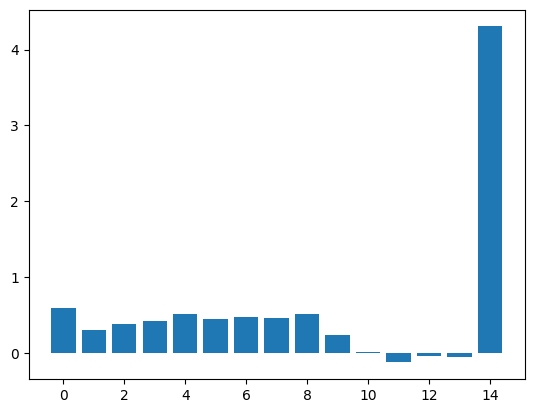

In [17]:
lrm = LogisticRegression()
# fit the model
lrm.fit(X_train, y_train)
yhat = lrm.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy:', accuracy)

# get importance
importance = lrm.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


While the accuracy on the test data was 100%, a simpler model is better.  Correlation between features needs to be considered in Logistic Regression models, so the model will be run again, this time only using feature 14 (result), feature 0 (A1_Score), and feature 8 (A7_Score).

Accuracy: 1.0
Feature: 0, Score: 0.40719
Feature: 1, Score: 0.17113
Feature: 2, Score: 4.59612


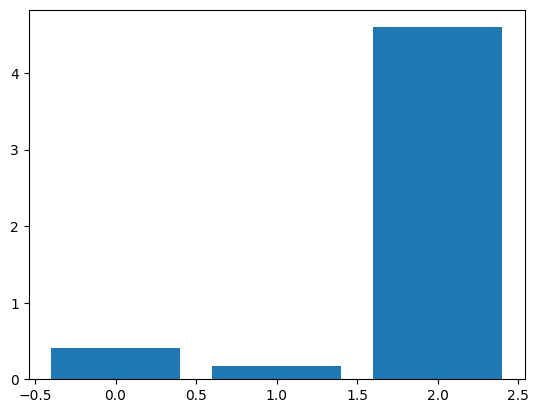

In [18]:
#Create dataframe with only the 3 most important features
Top3=Xclean.copy()
Top3.drop(['A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'jaundice', 'family_pdd', 'gender', 'age'],axis=1, inplace=True)
#Split Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(Top3, y, test_size=0.2, random_state=42)

# build model
lrm = LogisticRegression()
# fit the model
lrm.fit(X_train, y_train)
yhat = lrm.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy:', accuracy)

# get importance
importance = lrm.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()



In [19]:
Just_result=Top3.copy()
Just_result.drop(['A1_Score', 'A7_Score'],axis=1, inplace=True)

#Split Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(Just_result, y, test_size=0.8, random_state=42)

# build model
lrm = LogisticRegression()
# fit the model
lrm.fit(X_train, y_train)
yhat = lrm.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print('Accuracy:', accuracy)


Accuracy: 1.0


It appears a simple logistic regression model with one aggregate parameter, result performs just as good as the 15 feature model.  

###  Results and Analysis

The goal of this project was to use a data set containing the AQ-10 responses and various demographic information of 704 adults to create a model that predicted if the person had ASD.  The data was cleaned and evaluated for imbalance and feature correlation.  It was found that one dominate feature, result, the aggregate score from the AQ-10 survey was the only predictor needed to determine if a person had ASD.  

As a baseline model, a Random Forest Classification model with 100 trees was created and predicted the outcome with 100% accuracy.  Because a perfect model was created on the first try (kinda boring!), a test of accuracy based on number of trees was performed to see that only 8 trees were necessary to acheive perfect predictions (as shown in visualization above).

Then a Logistic Regression model was created using all of the features, then the Top3 features (see in bar graph above that the result parameter still dominated), then only the results parameter.  All the models were able to predict whether a patient had ASD with 100% accuracy.

### Discussion and Conclusion

**Learning and Takaways:**  I really enjoyed this project.  Because I don't have much experience in the field, and in the course most of the visualization code was given to us, my biggest learning was around creating visualization.  I discovered a library that created Cramer's V coefficient Heat Maps for a given dataframe.  I also manually created a 2x5 subplot of pie charts to check for feature imbalance.  I also created a Jupyter Notebook for the first time, which required learning a little bit of Markdown which I haven't previously used.  I also learned/experienced a general start to finish workflow for a machine learning project, and that I enjoyed completing the work!

**Disappointments:**  The data set I chose had a feature that must've been very correlated with the target data.  Unfortunately I didn't think to test for that, as I trusted data from the recommended UCI ML Repo would be good to use for the project.  While it was very easy to acheive 100% accuracy with the models, I still feel I learned a good amount from the project and am excited to extend my learning to Kaggle competitions, etc. 

**Improvements**  The improvements I'd make are directly correlated to my disappoints with the project.  I wish I would've chosen a more challenging data set with which to work.